# Fisher forecast for DES-Y3 3x2-point constraint on LCDM and beyond-LCDM parameters

In this notebook we use [```jax-cosmo```](https://github.com/DifferentiableUniverseInitiative/jax_cosmo) to perform a Fisher forecast for the constraint on cosmological parameters from [DES-Y3 3x2-point data vector](https://des.ncsa.illinois.edu/releases/y3a2/Y3key-products).

The cosmological parameters include:

$[\Omega_m,\Omega_b,h,n_s,S_8,w_0,w_a,\gamma_0,\gamma_1]$

where $[\Omega_m,\Omega_b,h,n_s,S_8]$ are the standard, i.e. $\Lambda$CDM parameters,

while $[w_0,w_a]$ are the DE equation of state parameters, $w(a)=w_0+w_a(1-a)=w_0+w_a\frac{z}{1+z}$ [[1]](https://arxiv.org/abs/astro-ph/0208512),

and $[\gamma_0,\gamma_1]$ are the growth-index parameters, $\gamma(z)=\gamma_0+\gamma_1\frac{z^2}{1+z}$ [[2]](https://arxiv.org/abs/2304.07281).

This is part of the project documented in [[3]](https://www.overleaf.com/read/tmggbrcfsncd) on Overleaf.


## Load the python modules

In [16]:
## os library for path
import os.path

## jax library for autodiff
import jax
## enable x64
jax.config.update("jax_enable_x64", True)

## jax-cosmo library
import jax_cosmo as jc

## jax numpy API
import jax.numpy as np

## astropy module to handle fits file
from astropy.io import fits

## matplotlib library
import matplotlib
from matplotlib.ticker import MultipleLocator, FormatStrFormatter # for tick format
from matplotlib import cm # for colormaps
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
## personal preference for matplotlib fonts
plt.style.use('Minh_paper_style')

## Retrieve DES-Y3 data vector

In this first section, we load the redshift distributions of the DES-Y3 lens and source galaxy samples.

For source galaxies, there is only one common source sample. For lens galaxies, there are two lens samples: MagLim (DES Y3 fiducial sample) and redMaGiC.

As for data files, there are two files, one for each lens sample. The source galaxy sample is stored in both files as two identical copies.

### Retrieve the data files in fits format

#### DES Y3 - MagLim samples

MagLim is the lens sample in the fiducial DES Y3 3x2-point analysis and result.

In [2]:
maglim_len_and_source_file='2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits'
if not os.path.isfile(maglim_len_and_source_file):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y3a2_files/datavectors/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits;

#### DES Y3 - RedMaGiC samples

In [3]:
redmagic_len_and_source_file='2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits'
if not os.path.isfile(redmagic_len_and_source_file):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y3a2_files/datavectors/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits;

### Retrieve header and data from the fit file

#### MagLim samples: source is specified in Table 6, lens is specified in Table 7

In [4]:
source_tab=6
lens_tab=7
maglim_nz_source_header=fits.getheader(maglim_len_and_source_file, source_tab)
maglim_nz_source=fits.getdata(maglim_len_and_source_file, source_tab)

maglim_nz_lens_header=fits.getheader(maglim_len_and_source_file, lens_tab)
maglim_nz_lens=fits.getdata(maglim_len_and_source_file, lens_tab)

#### redMaGiC samples: source is specified in Table 6, lens is specified in Table 7 (same as MagLim)

In [5]:
## Uncomment these lines and specify the source and lens table IDs if they are:
## a/ not yet specified, or b/ different from the above
#source_tab=6
#lens_tab=7

redmagic_nz_source_header=fits.getheader(redmagic_len_and_source_file, source_tab)
redmagic_nz_source=fits.getdata(redmagic_len_and_source_file, source_tab)

redmagic_nz_lens_header=fits.getheader(redmagic_len_and_source_file, lens_tab)
redmagic_nz_lens=fits.getdata(redmagic_len_and_source_file, lens_tab) 

## Investigate the redshift distributions of the samples

### Retrieve the centrals and $n(z)$s of the redshift bins

#### MagLim samples: 4 source bins, 6 lens bins

There are, in total, **six** tomographic redshift bins of MagLim lenses. After DES Y3 unblinding, however, issues were discovered in the two highest redshift bins leading to their removals from the analysis. See [https://arxiv.org/abs/2105.13549] for details.

Therefore, in this forecast, we use the *first* **four** bins only.

In [26]:
## Specify the numbers of bins here
maglim_source_nbins=4
maglim_lens_nbins=4

maglim_zs = maglim_nz_source['Z_MID']
maglim_nzs = [ maglim_nz_source['BIN%d'%(i+1)] for i in range(maglim_source_nbins)]
## Check if these are given in gal/arcmin^{2} !
maglim_ngals = [ maglim_nz_source_header['NGAL_%d'%(i+1)] for i in range(maglim_source_nbins) ]

maglim_zl = maglim_nz_lens['Z_MID']
maglim_nzl = [ maglim_nz_lens['BIN%d'%(i+1)] for i in range(maglim_lens_nbins)]
## Really, make sure these are given in gal/arcmin^{2} !!
maglim_ngall = [ maglim_nz_lens_header['NGAL_%d'%(i+1)] for i in range(maglim_lens_nbins) ]

In [29]:
maglim_ngals=np.asarray(maglim_ngals)
maglim_nzs=np.asarray(maglim_nzs)
print(maglim_ngals.sum())
print(maglim_nzs.sum())

5.899887956006901
3.9128433896247596


#### RedMaGiC samples: 4 source bins, 5 lens bins (note the difference with MagLim)

In [7]:
## Specify the numbers of bins here
redmagic_source_nbins=4
redmagic_lens_nbins=5

redmagic_zs = redmagic_nz_source['Z_MID']
redmagic_nzs = [ redmagic_nz_source['BIN%d'%(i+1)] for i in range(redmagic_source_nbins)]
## Are you sure these are given in gal/arcmin^2 ?
redmagic_ngals = [ redmagic_nz_source_header['NGAL_%d'%(i+1)] for i in range(redmagic_source_nbins) ]

redmagic_zl = redmagic_nz_lens['Z_MID']
redmagic_nzl = [ redmagic_nz_lens['BIN%d'%(i+1)] for i in range(redmagic_lens_nbins)]
## Are you really sure these are given in gal/arcmin^2 ??
redmagic_ngall = [ redmagic_nz_lens_header['NGAL_%d'%(i+1)] for i in range(redmagic_lens_nbins) ]

### Visualize the $n(z)$

#### MagLim redshift distributions

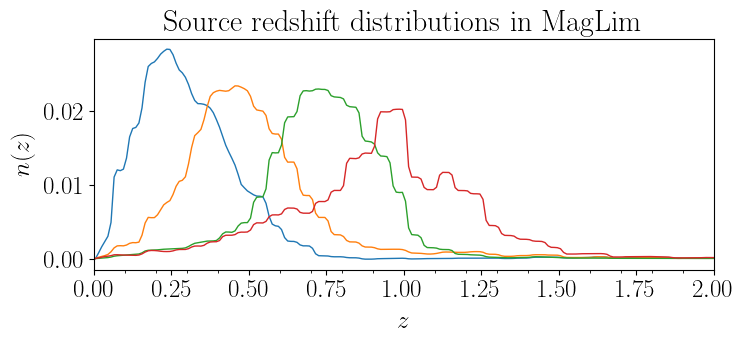

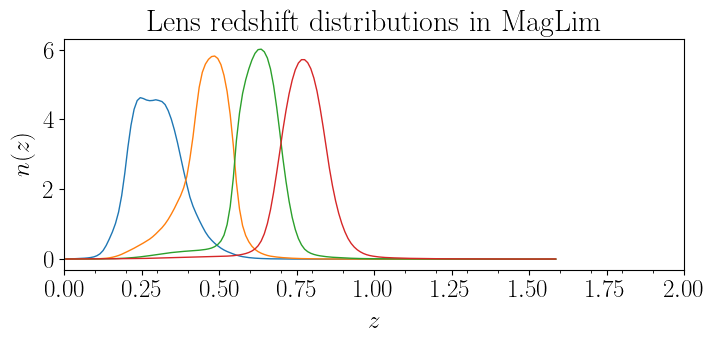

In [8]:
fig,ax=plt.subplots(figsize=(8,3))
for i in range(maglim_source_nbins):
    ax.plot(maglim_zs, maglim_nzs[i])
ax.set_xlim(0,2); ax.xaxis.set_minor_locator(MultipleLocator(0.1)); ax.set_xlabel('$z$'); ax.set_ylabel('$n(z)$')
ax.set_title('Source redshift distributions in MagLim')
fig,ax=plt.subplots(figsize=(8,3))
for i in range(maglim_lens_nbins):
   ax.plot(maglim_zl, maglim_nzl[i])
ax.set_xlim(0,2); ax.xaxis.set_minor_locator(MultipleLocator(0.1)); ax.set_xlabel('$z$'); ax.set_ylabel('$n(z)$')
ax.set_title('Lens redshift distributions in MagLim');

#### redMaGiC redshift distributions

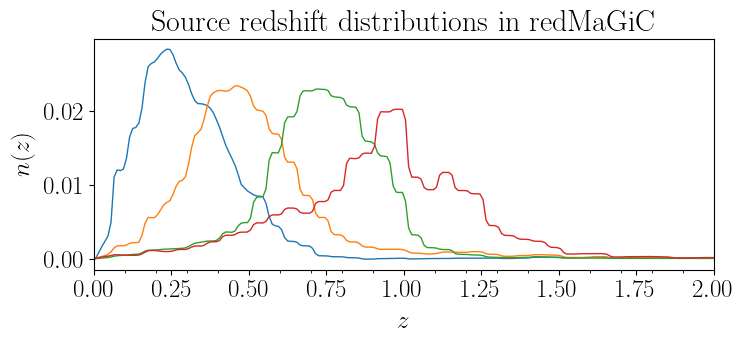

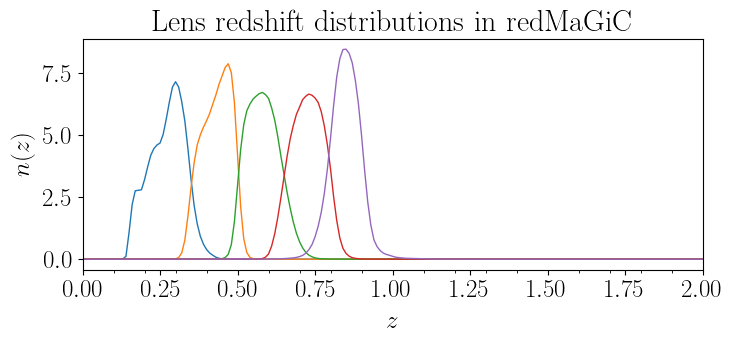

In [9]:
fig,ax=plt.subplots(figsize=(8,3))
for i in range(redmagic_source_nbins):
    ax.plot(redmagic_zs, redmagic_nzs[i])
ax.set_xlim(0,2); ax.xaxis.set_minor_locator(MultipleLocator(0.1)); ax.set_xlabel('$z$'); ax.set_ylabel('$n(z)$')
ax.set_title('Source redshift distributions in redMaGiC')
fig,ax=plt.subplots(figsize=(8,3))
for i in range(redmagic_lens_nbins):
   ax.plot(redmagic_zl, redmagic_nzl[i])
ax.set_xlim(0,2); ax.xaxis.set_minor_locator(MultipleLocator(0.1)); ax.set_xlabel('$z$'); ax.set_ylabel('$n(z)$')
ax.set_title('Lens redshift distributions in redMaGiC');

We have visually verified that the source sample stored in the two fits files is the same sample. The numerical test below should return ```True``` if that is indeed the case.

In [10]:
redmagic_nzs=np.asarray(redmagic_nzs)
maglim_nzs=np.asarray(maglim_nzs)
np.array_equal(redmagic_nzs,maglim_nzs)

Array(True, dtype=bool)

Alright! So from now on, we can be confident to use only one of the two copies of the source sample. We must not use both to avoid double-counting the data.

## Build differentiable $n(z)$ kernels from the data using jax-cosmo kernel density estimation (KDE) for redshift distributions

### Setup generic jax-cosmo redshift KDE params

In [11]:
## Currently adopting the same values for both MagLim and redMaGiC samples
KDE_bw_s=np.array([0.015, 0.011, 0.008, 0.015]) # bandwidth of the source samples KDE
KDE_zmax_s=maglim_zs.max() # the cutoff redshift for source samples in the KDE
KDE_bw_l=np.array([0.004, 0.006, 0.004, 0.005]) # bandwidth of the lens samples KDE
KDE_zmax_l=maglim_zl.max() # the cutoff redshift for lens samples in the KDE

### Call the jax-cosmo redshift KDE to get differentiable $n(z)$

#### MagLim KDEs

We perform KDEs on all six bins of the MagLim lens sample. But remember that we should only use the first four bins for the reason mentioned above.

In [17]:
nzs_s = [jc.redshift.kde_nz(maglim_zs.astype('float32'),
                        maglim_nzs[i].astype('float32'), 
                        bw=KDE_bw_s[i],
                        gals_per_arcmin2=maglim_ngals[i],
                        zmax=KDE_zmax_s)
       for i in range(maglim_source_nbins)]
maglim_nzs_l = [jc.redshift.kde_nz(maglim_zl.astype('float32'),
                                   maglim_nzl[i].astype('float32'),
                                   bw=KDE_bw_l[i],
                                   gals_per_arcmin2=maglim_ngall[i],
                                   zmax=KDE_zmax_l)
       for i in range(maglim_lens_nbins)]

#### redMaGiC KDEs

In [18]:
redmagic_nzs_s = [jc.redshift.kde_nz(redmagic_zs.astype('float32'),
                        redmagic_nzs[i].astype('float32'), 
                        bw=KDE_bw_s[i],
                        gals_per_arcmin2=redmagic_ngals[i],
                        zmax=KDE_zmax_s)
       for i in range(redmagic_source_nbins)]
redmagic_nzs_l = [jc.redshift.kde_nz(redmagic_zl.astype('float32'),
                                   redmagic_nzl[i].astype('float32'),
                                   bw=KDE_bw_l,
                                   gals_per_arcmin2=redmagic_ngall[i],
                                   zmax=redmagic_zl.max())
       for i in range(redmagic_lens_nbins)]

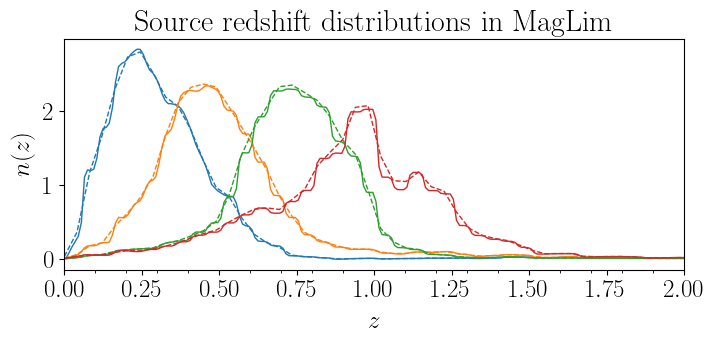

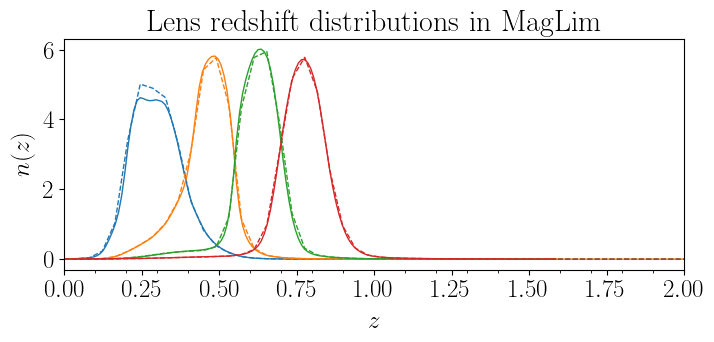

In [19]:
z=np.linspace(0.0,2.0)
fig,ax=plt.subplots(figsize=(8,3))
for i in range(maglim_source_nbins):
    ax.plot(maglim_zs, maglim_nzs[i]/(maglim_zs[1]-maglim_zs[0]),ls='-',color='C%d'%i)
    ax.plot(z, nzs_s[i](z),ls='--',color='C%d'%i)
ax.set_xlim(0,2); ax.xaxis.set_minor_locator(MultipleLocator(0.1)); ax.set_xlabel('$z$'); ax.set_ylabel('$n(z)$')
ax.set_title('Source redshift distributions in MagLim')
fig,ax=plt.subplots(figsize=(8,3))
for i in range(maglim_lens_nbins):
   ax.plot(maglim_zl, maglim_nzl[i],ls='-')
   ax.plot(z, maglim_nzs_l[i](z),ls='--',zorder=2,color='C%d'%i)
ax.set_xlim(0,2); ax.xaxis.set_minor_locator(MultipleLocator(0.1)); ax.set_xlabel('$z$'); ax.set_ylabel('$n(z)$')
ax.set_title('Lens redshift distributions in MagLim');

## Define utility functions that are not yet supported by jax-cosmo but useful for DES analyses 

### Specify standard input parameter(s)

In [ ]:
## The number of cosmological parameters in the parameter vector, i.e. the number of cosmo parameters we vary
cosmo_param_nr=5

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from jax.scipy.linalg import eigh, inv
from jax.scipy.stats import norm

def plot_contours(cov, pos, inds, cls=np.array([0.6827, 0.9545]), ax=None, **kwargs):
    """
    Plot 2D parameter contours given a Hessian matrix of the likelihood
    Parameters:
    -----------
    fisher : (M, M) array_like
        Input Fisher matrix.
    pos : (M,) array_like
        Fiducial parameter values.
    inds : (2,) array_like
        Parameter indices.
    cl1, cl2 : float
        Confidence levels of ellipse contours.
    """
    
    def eigsorted(cov):
        vals, vecs = eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    def sigma_marg(cov, i):
        return np.sqrt(cov[i, i])
        
    cov = cov[inds][:, inds]
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    cls = .5*(1+cls)
    nstds = norm.ppf(cls)
    #nstd1 = norm.ppf(0.5 * (1 + cl1))
    #nstd2 = norm.ppf(0.5 * (1 + cl2))

    ellip1 = Ellipse(xy=pos[inds], width=2.0 * nstds[0] * np.sqrt(vals[0]),
                     height=2.0 * nstds[0] * np.sqrt(vals[1]), angle=theta, alpha=0.8,**kwargs)
    ellip2 = Ellipse(xy=pos[inds], width=2.0 * nstds[1] * np.sqrt(vals[0]),
                     height=2.0 * nstds[1] * np.sqrt(vals[1]), angle=theta, alpha=0.2,**kwargs)
    ellips=[ellip1,ellip2]

    if ax is None:
        ax = plt.gca()

    for ellip in ellips:
       ax.add_artist(ellip)

    nstdmax = max(nstds)
    sx = nstdmax * sigma_marg(cov, 0)
    sy = nstdmax * sigma_marg(cov, 1)
    ax.set_xlim(pos[inds[0]] - 1.5*sx, pos[inds[0]] + 1.5*sx)
    ax.set_ylim(pos[inds[1]] - 1.5*sy, pos[inds[1]] + 1.5*sy)

    return ellips

def plot_Gaussian(cov, pos, ind, cl=0.9545, ax=None, **kwargs):
  mu = pos[ind]
  sigma = np.sqrt(cov[ind,ind])
  if ax is None:
    ax = plt.gca()
  num = 100
  if 'num' in kwargs.keys():
     num = kwargs['num']
  nstd = norm.ppf(.5*(1+cl))
  x = np.linspace(mu-1.5*nstd*sigma, mu+1.5*nstd*sigma, num=num, endpoint=True)
  N = np.exp(-.5*((x-mu)/sigma)**2)
  ax.plot(x, N, **kwargs)
  ax.set_xlim((x[0], x[-1]))


## The correct way to have a varying number of cosmological parameters and number of z bins)
## would have been inplementing variables controls that number and including some ```if``` statements
## but for the sake of simplicity (and performance) in this example, we're not doing so
## and instead specifying that number as a global variable directly above
def get_params_vec(cosmo,  b_l, ia, dz_l, m_s, dz_s):
#def get_params_vec(cosmo, b_l, dz_l):
    """
    Packs cosmological and DES source and lens systematic parameters
    into a single 1D parameter vector (stored in a numpy array)
    """
    b1, b2, b3, b4 = b_l
    A, eta = ia
    dz1_l, dz2_l, dz3_l, dz4_l = dz_l
    m1, m2, m3, m4 = m_s
    dz1_s, dz2_s, dz3_s, dz4_s = dz_s
    return np.array([ 
        # Cosmological parameters [Omega_m, Omega_b, h, S8, ns, gamma, w0, wa] 
        #cosmo.Omega_k,
        cosmo.Omega_m, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.S8,
        #cosmo.w0, cosmo.wa,
        #cosmo.gamma0, cosmo.gamma1,
        # Lens - Galaxy bias
        b1, b2, b3, b4,
        # Source - Galaxy IA
        A, eta,
        # Lens - Photometric redshift calibration systematics
        dz1_l, dz2_l, dz3_l, dz4_l,
        # Source - Shear measurement calibration systematics
        m1, m2, m3, m4,
        # Source - Photometric redshift calibration systematics
        dz1_s, dz2_s, dz3_s, dz4_s,
    ])

def unpack_params_vec(params):
    """
    Unpacks a 1D parameter vector (stored in a numpy array)
    into cosmological and DES source and lens systematic parameters
    """
    # Retrieve cosmology
    cosmo = params[0:cosmo_param_nr]
    b1,b2,b3,b4 = params[cosmo_param_nr:cosmo_param_nr+4]
    A = params[cosmo_param_nr+4]
    eta = params[cosmo_param_nr+5]
    dz1_l,dz2_l,dz3_l,dz4_l = params[cosmo_param_nr+6:cosmo_param_nr+10]
    m1,m2,m3,m4 = params[cosmo_param_nr+10:cosmo_param_nr+14]
    dz1_s,dz2_s,dz3_s,dz4_s = params[cosmo_param_nr+14:cosmo_param_nr+18]
    return cosmo, [b1,b2,b3,b4],  [A, eta], [dz1_l,dz2_l,dz3_l,dz4_l], [m1,m2,m3,m4], [dz1_s,dz2_s,dz3_s,dz4_s]

## Uncomment these lines below to double-check the two function behaviors
#p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              #[1., 2.,0.62],[0.0,0.0,0.0,0.0],[1.0,1.0,1.0,1.0])
#print(unpack_params_vec(p))

## Define fiducial cosmological parameters and systematics parameters

### Define fiducial cosmology

#### Specify Planck18 best-fit cosmology

See the ``Plik best fit'' column in Table 1 of [Planck 2018 paper](https://arxiv.org/abs/1807.06209)

In [ ]:
PL18_h=0.6732
PL18_omegac=0.12011/(PL18_h**2)
PL18_omegab=0.022383/(PL18_h**2) # won't vary in this example
PL18_sigma8=0.812
PL18_ns=0.96605
## Baseline PL18 assumes LCDM, hence omegak=0, w0=-1,wa=0. Here we specify but won't vary them in the forecasts
PL18_omegak=0.0
PL18_w0=-1.0
PL18_wa=0.0
## Gamma Extension
## After cross-check the jax-cosmo Fisher contours with the counterparts from CCL, we can include gamma.
## The reason not to include gamma in the comparison against CCL is because gamma is not available in CCL
GR_gamma0=0.55
GR_gamma1=0.

#### Create a jax-cosmo Cosmology object for the fiducial cosmology

In [13]:
fid_cosmo = jc.Cosmology(Omega_m=PL18_omegac+PL18_omegab,
                         Omega_c=PL18_omegac,
                         Omega_b=PL18_omegab,
                         h=PL18_h,
                         n_s=PL18_ns,
                         sigma8=PL18_sigma8,
                         S8=PL18_sigma8*((PL18_omegac+PL18_omegab)/0.3)**0.5,
                         #Omega_k=PL18_omegak,w0=PL18_w0,wa=PL18_wa, gamma0=GR_gamma0, gamma1=GR_gamma1)
                         Omega_k=PL18_omegak,w0=PL18_w0,wa=PL18_wa, gamma0=None, gamma1=None)

NameError: name 'jc' is not defined

### Specify systematic parameters for source galaxies

There are three sources of systematics for source galaxies:

- Shear measurement calibration error;
- Photometric redshift (photo-z) calibration error;
- Intrinsic Alignment (IA) of source galaxies with the underlying tidal field, hence themselves.


#### Shear measurement calibration systematics

We have four parameters $m^i$ for four redshift bins of the source samples.
For their fiducial values, we use the priors in Table 1 of [the DES Y3 3x2-point paper](https://arxiv.org/abs/2105.13549). They can be varied within reasonable ranges.

In [ ]:
m_s = [-6e-3,-2e-2,-2.4e-2,-3.7e-2]

#### Photo-z calibration systematics

We have four parameters $\Delta z_s^i$ for four redshift bins of the source samples. We use the priors in Table 1 of [the DES Y3 3x2-point paper](https://arxiv.org/abs/2105.13549). They can also be varied within reasonable ranges.

In [ ]:
dz_s = [0.0,0.0,0.0,0.0]
#dz_s = [1e-2, -1e-2, 2e-3, -2e-3]

#### Intrinsic Alignment (of source galaxies)

DES NLA model for IA assumes the following form to account for redshift evolution of IA:
$$A(z)=A_0\left[\frac{1+z}{1+z_0}\right]^\eta$$
where the pivot redshift $z_0$ is fixed at 0.62.
For fiducial values, we use the means of posteriors in the third row of Table 3 of [the DES Y3 cosmic shear paper](https://arxiv.org/pdf/2105.13544.pdf)

In [ ]:
A0, eta = [0.36,1.66]
z0=0.62

### Specify systematic parameters for lens galaxies

There are two sources of systematics for lens galaxies:

- Photometric redshift calibration error;
- Galaxies are biased tracer of the underlying matter distribution.

#### Photometric (Photo-z) calibration systematics

We use the priors in Table 1 of [the DES Y3 3x2-point paper](https://arxiv.org/abs/2105.13549). They can also be varied within reasonable ranges.

In [ ]:
maglim_dz_l = [-0.9e-2,-3.5e-2,-0.5e-2,-0.7e-2]

#### Galaxy bias systematics

Here we take the fiducial values for the linear galaxy bias parameters $b^i_l$ of lens galaxies from the constraints in the first row of Table V of [DES Y3 3x2-point paper](https://arxiv.org/abs/2105.13549). Note that these values are for the fiducial MagLim sample.

In [ ]:
maglim_b_l = [1.49,1.69,1.91,1.79]

### Pack a parameter vector including both cosmological and systematic parameters

In [ ]:
fid_params = get_params_vec(fid_cosmo,
                            maglim_b_l,
                            [A0, eta],
                            maglim_dz_l,
                            m_s,
                            dz_s)

## Compute the mean of the 3x2-point data vector using the ```jax-cosmo``` library

### Specify standard input parameter(s) for the function

In [ ]:
## Specify a range of multipole ell values
ell_max=400.
ell = np.logspace(1,np.log10(ell_max))

### Put everything together and define the ```jax-cosmo``` function using just-in-time compilations

Note that here we specify the fiducial lens sample as MagLim. We include all defined sources of systematics and their associated nuisance parameters in the computation.

In [ ]:
@jax.jit
def compute_3x2pt_mean(params,nzs_source,nzs_lens=maglim_nzs_l,ell=ell,zpivot_ia=z0):
    """
    Returns the mean signal of a 3x2-point data vector
    """
    ## First unpack parameter vector
    cosmo_params, b_l, (A, eta), dz_l, m, dz_s = unpack_params_vec(params)
    #cosmo_params, (A, eta), m, dz_s = unpack_params_vec(params)

    ## Specify cosmology
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         n_s=cosmo_params[3],
                         S8=cosmo_params[4], sigma8=cosmo_params[4]/(cosmo_params[0]/0.3)**0.5,
                         w0=PL18_w0, wa=PL18_wa,
                         gamma0=None, gamma1=None)
                         #w0=cosmo_params[5], wa = cosmo_params[6],
                         #gamma0=cosmo_params[7], gamma1=cosmo_params[8])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    # Define IA model, IA_zpivot=0.62 is fixed between DES Y1 and Y3
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l]

    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=a_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l_sys, b)]
    #probes = [jc.probes.NumberCounts(nzs_l_sys, b)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl.flatten()

### Call the function for the first time, so there will be some waiting for compilation

In [ ]:
means = compute_3x2pt_mean(fid_params,nzs_s)
#%timeit compute_3x2pt_mean(fid_params,nzs_s).block_until_ready()

In [ ]:
fig, ax = plt.subplots()
ax.loglog(ell,ell*means[0],c='mediumseagreen',label=r'fiducial cosmo')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell C_\ell$')
ax.legend(frameon=False)
#ax.set_ylim(1e-10,1e-8)
#ax.axhline(y=1E-9,ls='--',c='k')
#ax.axvline(x=1E2,ls='--',c='k')

## Compute the covariance at the fiducial cosmology using ```jax-cosmo```

### Define the function

Again set the fiducial lens sample to MagLim and include all sources of systematics for lens and source galaxy samples, as above, for consistency.

In [ ]:
@jax.jit
def compute_gaussian_covariance_3x2(params,nzs_source,nzs_lens=maglim_nzs_l,ell=ell,zpivot_ia=z0,f_sky=0.25):
    """
    Rerturns the Gaussian covariance for a 3x2pt data vector
    """
    ## First unpack parameter vector
    cosmo_params, b_l,  (A, eta), dz_l, m, dz_s = unpack_params_vec(params)
    #cosmo_params, (A, eta), m, dz_s = unpack_params_vec(params)  

    ## Specify cosmology
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         n_s=cosmo_params[3],
                         S8=cosmo_params[4], sigma8=cosmo_params[4]/(cosmo_params[0]/0.3)**0.5,
                         w0=PL18_w0, wa=PL18_wa,
                         gamma0=None, gamma1=None)
                         #w0=cosmo_params[5], wa = cosmo_params[6],
                         #gamma0=cosmo_params[7], gamma1=cosmo_params[8])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model, IA_zpivot=0.62 is fixed between DES Y1 and Y3
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l]

    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=a_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l_sys, b)]
    #probes = [jc.probes.NumberCounts(nzs_l_sys, b)]
    
    cl_signal = jc.angular_cl.angular_cl(cosmo, ell, probes)
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=f_sky, sparse=False)
    
    return cov

### Call the function to get the covariance and compute its inverse

The inverse of the covariance matrix is usually referred to as the *precision matrix*.

In [ ]:
full_sky=41252.9612  # full sky in square degrees
desy3_sky=5000.  # LSST sky coverage; in square degrees
desy3_fsky=desy3_sky/full_sky  # fraction of the sky covered by LSST

In [ ]:
cov_mat = compute_gaussian_covariance_3x2(fid_params,nzs_s,f_sky=desy3_fsky)
prc_mat = jax.scipy.linalg.inv(cov_mat)

## Compute the Jacobian using jax-cosmo

We wrote a function to compute the mean of the 3x2-point data vector. We can use that to compute the Jacobian using ```jax-cosmo```

In [ ]:
# Defining jax-cosmo jacobian
compute_3x2pt_jac = jax.jit(jax.jacfwd(compute_3x2pt_mean))

In [ ]:
#del(jacobian)
jacobian = compute_3x2pt_jac(fid_params,nzs_s)
#%timeit compute_3x2pt_jac(fid_params,nzs_s).block_until_ready()

## Compute Fisher matrix

Putting the mean and covariance together, we can now compute the Fisher matrix.
NOTE: This is, strictly speaking, only valid for Gaussian likelihoods. With ```jax-cosmo``` there is another way to compute the Fisher matrix wherein users manually define their likelihood. We will explore it below as a double-check.

In [ ]:
## Take the matrix product
#del(fisher)
fisher = jacobian.T @ prc_mat @ jacobian
print(fisher.shape)

In [ ]:
lens_photoz_priors = 1./np.array([0.7e-2**2,1.1e-2**2,0.6e-2**2,0.6e-2**2])
fisher=fisher.at[cosmo_param_nr+6:cosmo_param_nr+10,cosmo_param_nr+6:cosmo_param_nr+10].add(lens_photoz_priors);

shear_calibration_priors = 1./np.array([0.9e-2**2,0.8e-2**2,0.8e-2**2,0.8e-2**2])
fisher=fisher.at[cosmo_param_nr+10:cosmo_param_nr+14,cosmo_param_nr+10:cosmo_param_nr+14].add(shear_calibration_priors);

source_photoz_priors = 1./np.array([1.8e-2**2,1.5e-2**2,1.1e-2**2,1.7e-2**2])
fisher=fisher.at[cosmo_param_nr+14:cosmo_param_nr+18,cosmo_param_nr+14:cosmo_param_nr+18].add(source_photoz_priors);

```fisher``` is the full Fisher matrix. Below we can plot the whole matrix for a quick visual inspection. There should be no complain about any ```NaN``` of ```Inf``` when estimating the contours.
NOTE: This can take a while for a large Fisher matrix.

In [ ]:
#Methods to easily save and load fisher matrices to storage
from numpy import savetxt, loadtxt

def saveFisher(fid_vals, fisher, fname='LCDM_S8_DESY3_fisher.csv', delimiter=',', **kwargs):
   mat = np.append(fisher, np.reshape(fid_vals, (1, fisher.shape[0])), axis=0)
   savetxt(fname, mat, delimiter=delimiter, **kwargs)


def loadFisher(fname : str, delimiter=',', **kwargs):
   mat = loadtxt(fname, delimiter=delimiter, **kwargs)
   fisher = mat[:mat.shape[1], :mat.shape[1]]
   fid_vals = mat[mat.shape[1], :]
   return fid_vals, fisher

In [ ]:
saveFisher(fid_params, fisher, fname='LCDM_S8-Omegam_DESY3_fisher.csv')

In [ ]:
extract_params=5
param_names = (r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', 'h', r'$n_s$', r'$S_8$')
               #r'$w_0$', r'$w_a$',
               #r'$\gamma_0$',r'$\gamma_1$')
               #r'$b_{l,1}$', r'$b_{l,2}$', r'$b_{l,3}$', r'$b_{l,4}$')

fisher_inv = jax.scipy.linalg.inv(fisher)

fig= plt.figure(figsize=(extract_params*1.5, extract_params*1.5))
plt.rcParams.update({
    "font.size": 10})
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(extract_params):
    for j in range(extract_params):
        if j<i:
            plt.subplot(extract_params,extract_params,i*extract_params+j+1)
            plot_contours(fisher_inv, fid_params, np.array([j,i]),fill=True,antialiased=True,color='mediumseagreen')
        if j==i:
            plt.subplot(extract_params, extract_params, i*extract_params+j+1)
            plot_Gaussian(fisher_inv, fid_params, i, color='mediumseagreen')
        if i == extract_params - 1:
            plt.xlabel(param_names[j])
        if j == 0:
            plt.ylabel(param_names[i])
fig.suptitle(r'DES Year-3 3x2-pt, priors on photo-z and shear calibration', fontsize=30)